# BIOINFO M224 - Project 6: Genotype Imputation

In [86]:
num_snps = 10000 # all snps in file

full.data = read.table('imputation_training.txt', header = TRUE)
data = t(head(full.data,num_snps))

alpha = 2/3 # this factor controls how many SNPs are allowed to cross the threshold

In [87]:
# shitty method: just look at average over everyone, pick the most common one
shitty_impute = data.frame(most_common = apply(data,2,function(x) names(which.max(table(x)))))
    
# super shitty method
ss_impute = data.frame(x= sample(c(0,1,2),replace = TRUE, size = num_snps))

In [88]:
cor_matrix = cor(data) # find the correlation matrix. NOT IDEAL FOR LARGE MATRICES.
diag(cor_matrix) = 0 # set diagonal to 0, so that the actual SNP is never included in the model (that would be cheating)
threshold = apply(abs(cor_matrix),2,max)*alpha # set threshold so that some SNPs always make it
mapping = data.frame(which(abs(cor_matrix) >= threshold, arr.ind = TRUE), row.names = NULL)
map2 = list()
for (i in 1:dim(data)[2]){
    map2[[i]] = mapping$col[mapping$row == i]
}

In [89]:
accuracy = array(data = NA, dim=dim(data)[2])
shitty_accuracy = array(data = NA, dim=dim(data)[2])
ss_accuracy = array(data = NA, dim=dim(data)[2])

for (current_snp in 1:dim(data)[2]){
    x = data[,map2[[current_snp]]]
    y = data[,current_snp]
    m = lm(y~x) # linear model!
    predictions = round(predict(m))
    correct = sum(predictions == y)
    total = length(y)
    accuracy[current_snp] = correct/total
    
    shitty_correct = sum(shitty_impute[current_snp,] == y)
    shitty_accuracy[current_snp] = shitty_correct/total
    
    ss_correct = sum(ss_impute[current_snp,] == y)
    ss_accuracy[current_snp] = ss_correct/total
}

In [90]:
df = data.frame(accuracy,shitty_accuracy,ss_accuracy)
summary(df)

    accuracy      shitty_accuracy   ss_accuracy    
 Min.   :0.5852   Min.   :0.3407   Min.   :0.0000  
 1st Qu.:0.9704   1st Qu.:0.4889   1st Qu.:0.1259  
 Median :0.9926   Median :0.6074   Median :0.2963  
 Mean   :0.9748   Mean   :0.6260   Mean   :0.3345  
 3rd Qu.:1.0000   3rd Qu.:0.7630   3rd Qu.:0.4889  
 Max.   :1.0000   Max.   :0.9259   Max.   :0.9111  

Warning message:
In hist.default(df$accuracy, 50, plot = FALSE, breaks = breaks): argument ‘freq’ is not made use ofWarning message:
In hist.default(df$shitty_accuracy, 50, plot = FALSE, breaks = breaks): argument ‘freq’ is not made use ofWarning message:
In hist.default(df$ss_accuracy, 50, plot = FALSE, breaks = breaks): argument ‘freq’ is not made use of

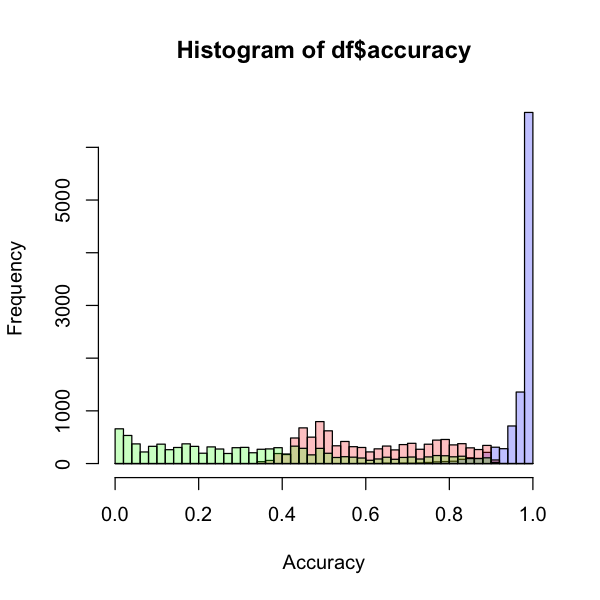

In [91]:
# Plotting the histogram
options(repr.plot.width = 5, repr.plot.height = 5)
breaks = seq(0,1,0.02)
p1 = hist(df$accuracy,50, plot=FALSE, breaks = breaks)
p2 = hist(df$shitty_accuracy,50, plot=FALSE, breaks = breaks)
p3 = hist(df$ss_accuracy,50, plot=FALSE, breaks = breaks)
plot( p1, col=rgb(0,0,1,1/4), xlim=c(0,1), xlab='Accuracy')  # first histogram
plot( p2, col=rgb(1,0,0,1/4), xlim=c(0,1), add=T)
plot( p3, col=rgb(0,1,0,1/4), xlim=c(0,1), add=T)

In [55]:
# The same thing as above, but for multiple (static) thresholds
# so that we can draw a figure
num_snps = 1000 # just looking at first 1000 for computation time reasons
thresholds = (1:10)/10

dff = data.frame()

for(threshold in thresholds){

    full.data = read.table('imputation_training.txt', header = TRUE)
    data = t(head(full.data,num_snps))

    # shitty method: just look at average over everyone, pick the most common one
    shitty_impute = data.frame(most_common = apply(data,2,function(x) names(which.max(table(x)))))

    # super shitty method
    ss_impute = data.frame(x= sample(c(0,1,2),replace = TRUE, size = num_snps))

    cor_matrix = cor(data)
    diag(cor_matrix) = 0

    mapping = data.frame(which(abs(cor_matrix) >= threshold, arr.ind = TRUE), row.names = NULL)
    map2 = list()
    for (i in 1:dim(data)[2]){
        map2[[i]] = mapping$col[mapping$row == i]
    }

    accuracy = array(data = NA, dim=dim(data)[2])
    shitty_accuracy = array(data = NA, dim=dim(data)[2])
    ss_accuracy = array(data = NA, dim=dim(data)[2])

    for (current_snp in 1:dim(data)[2]){
        y = data[,current_snp]

        shitty_correct = sum(shitty_impute[current_snp,] == y)
        shitty_accuracy[current_snp] = shitty_correct/total

        ss_correct = sum(ss_impute[current_snp,] == y)
        ss_accuracy[current_snp] = ss_correct/total

        if (length(map2[[current_snp]]) == 0){
            next
        }
        x = data[,map2[[current_snp]]]

        m = lm(y~x)
        predictions = round(predict(m))
        wrong = sum(predictions != y)
        correct = length(y) - wrong
        total = sum(!is.na(y))
        accuracy[current_snp] = correct/total
    }

    df = data.frame(accuracy,shitty_accuracy,ss_accuracy)
    summary(df)

    acc = accuracy
    acc[is.na(accuracy)] = 1/3

    dff = rbind(dff,data.frame(threshold, mean(acc), mean(shitty_accuracy), mean(ss_accuracy)))
}

dff

,threshold,mean.acc.,mean.shitty_accuracy.,mean.ss_accuracy.
1,0.1000000,0.9998667,0.6570222,0.3301111
2,0.2000000,0.9962963,0.6570222,0.3391481
3,0.3000000,0.9898000,0.6570222,0.3485037
4,0.4000000,0.9823778,0.6570222,0.3374000
5,0.5000000,0.9756222,0.6570222,0.3242519
6,0.6000000,0.9646815,0.6570222,0.3467704
7,0.7000000,0.9488667,0.6570222,0.3368889
8,0.8000000,0.9205630,0.6570222,0.3384593
9,0.9000000,0.8459185,0.6570222,0.3291630
10,1.0000000,0.5480000,0.6570222,0.3277407


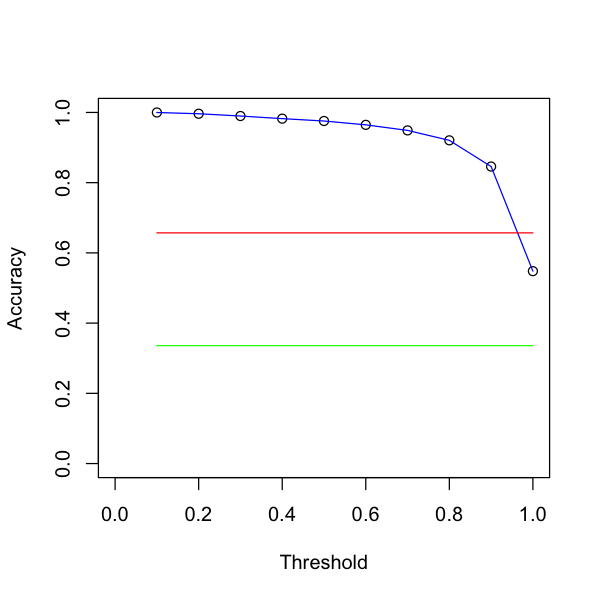

In [95]:
plot(dff$threshold, dff$mean.acc., xlim=c(0,1), ylim=c(0,1), xlab = 'Threshold', ylab = 'Accuracy')
lines(dff$threshold, dff$mean.acc., col='blue')
lines(dff$threshold, dff$mean.shitty_accuracy., col = 'red')
lines(dff$threshold, rep(mean(dff$mean.ss_accuracy.),10), col = 'green')

~Fin~